In [1]:
import tensorflow as tf
from keras.api.layers import LSTM, Dense
from keras.api.preprocessing import timeseries_dataset_from_array
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('climate.csv', sep=',')
data = df.iloc[:,[2]].values
data

array([[-8.02],
       [-8.41],
       [-8.51],
       ...,
       [-3.16],
       [-4.23],
       [-4.82]])

In [3]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [4]:
train_split = int(0.715 * int(df.shape[0]))
data = normalize(data, train_split)
train_data = data[:train_split]
val_data = data[train_split:]

In [5]:
#Xác định phương thức dự báo
past = 720
future = 72
step = 6
batch_size = 256

In [6]:
start = past + future
end = start + train_split
x_train = train_data
y_train = data[start:end]
sequence_length = int(past / step)

In [7]:
dataset_train = timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [8]:
x_end = len(val_data) - past - future
label_start = train_split + past + future
x_val = val_data[:x_end]
y_val = data[label_start:]

In [9]:
dataset_val = timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [12]:
from keras import Input
learning_rate = 0.5
model = tf.keras.Sequential()
model.add(Input(shape=(sequence_length, 1)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Huấn luyện
epochs = 10
history = model.fit(
dataset_train,
epochs=epochs,
validation_data=dataset_val,
#callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - loss: 1.7591 - val_loss: 1.8870
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 96s 82ms/step - loss: 1.3538 - val_loss: 1.7552
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - loss: 1.3456 - val_loss: 1.7346
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 94s 80ms/step - loss: 1.3425 - val_loss: 1.7293
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 88s 75ms/step - loss: 1.3413 - val_loss: 1.7276
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 90s 77ms/step - loss: 1.3408 - val_loss: 1.7270
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - loss: 1.3406 - val_loss: 1.7268
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 105s 89ms/step - loss: 1.3406 - val_loss: 1.7267
Epoch 9/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 111s 95ms/step - loss: 1.3405 - val_loss: 1.7266
Epoch 10/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 106s 91ms/step - loss: 1.3405 - val_loss: 1.7266


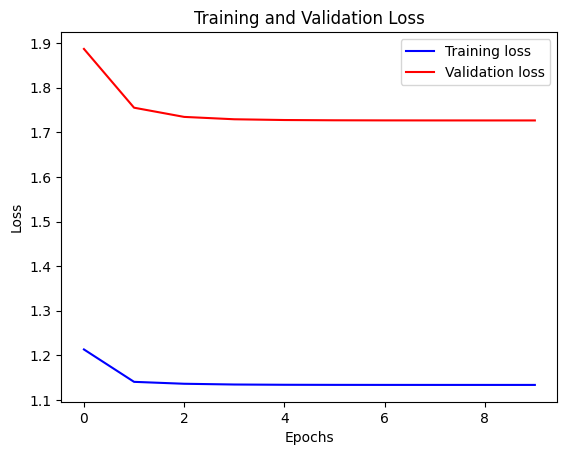

In [14]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
visualize_loss(history, "Training and Validation Loss")